In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import gc
import pandas as pd
import numpy as np
import chromadb

#Import library code
import dataloading
import model_functions
import data_vis

c:\Users\Aneesh\anaconda3\envs\test_requirements\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [3]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [4]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="10-27-25_model_embeddings")

In [5]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [6]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [7]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [8]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']

In [ ]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.569336,0.064754,0.092848,0.760222,-0.150801,0.386180,0.248047,0.268949,-1.268896,-1.091536,...,0.831522,0.244393,-0.402019,-0.137320,-0.712040,0.215911,-1.329741,-0.595130,0.908622,-1.547999
1,0.750805,0.750268,-0.422071,-0.562053,-0.667815,-0.136048,0.713448,-0.234454,-1.621611,-1.681074,...,0.837385,0.071509,0.555325,0.046563,0.473430,0.783841,-1.210032,-0.041179,1.241890,-0.708914
2,1.027584,0.258711,0.210378,0.108968,-0.886078,0.221975,0.675087,-0.219685,-1.451200,-1.502239,...,1.038834,0.143906,0.568044,-0.021338,-0.394325,0.834279,-1.283435,-0.149630,0.793170,-1.251510
3,0.957346,1.069157,-0.591534,-0.584165,-1.176969,-0.585506,0.750035,-0.246032,-1.621885,-1.709728,...,0.417510,0.042987,0.366288,0.027197,0.825463,0.595554,-1.221346,0.411931,1.103611,-0.146746
4,0.763690,0.914270,0.365205,0.843685,-0.514766,0.306982,0.773846,0.000808,-1.282980,-1.356925,...,0.660784,0.194246,-0.066093,-0.096482,0.095684,-0.157938,-1.501723,-0.069529,0.961301,-1.102488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.386086,-0.379566,-0.302332,1.126739,-0.144554,0.575698,0.029071,0.075767,-1.388028,-1.509967,...,1.074561,0.232958,-0.157211,-0.021435,-1.026339,0.268442,-1.450406,-0.694505,0.917295,-2.035544
1494,1.210871,1.124817,-0.227941,-1.051633,-1.198499,-0.651214,0.564110,0.001891,-1.858654,-1.355660,...,0.655259,0.041204,0.260934,0.166388,0.816875,0.902991,-1.027448,0.324435,0.855961,-0.196488
1495,0.534254,0.145705,-0.216860,0.959070,-0.256555,0.632551,0.328294,0.216309,-1.375377,-1.152329,...,1.482429,0.221542,0.377994,-0.370812,-0.765767,0.543112,-1.539077,-0.588633,0.984395,-1.608211
1496,1.167729,1.173822,-0.169757,-0.141228,-1.263351,-0.117545,0.870357,-0.394756,-1.538204,-1.550972,...,0.511238,0.058824,0.644923,-0.122036,0.466971,0.532705,-1.220923,0.236009,0.870148,-0.229255


In [10]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)

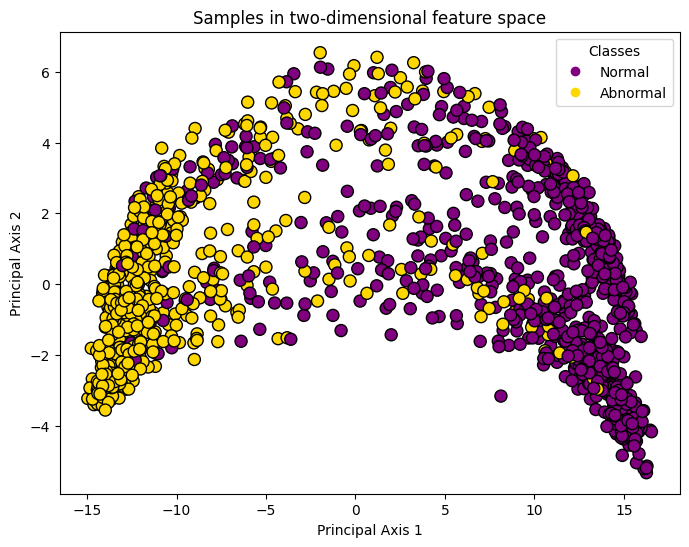

In [11]:
data_vis.plot_data(reduced_embeddings, labels)

Accuracy: 0.8731642189586115


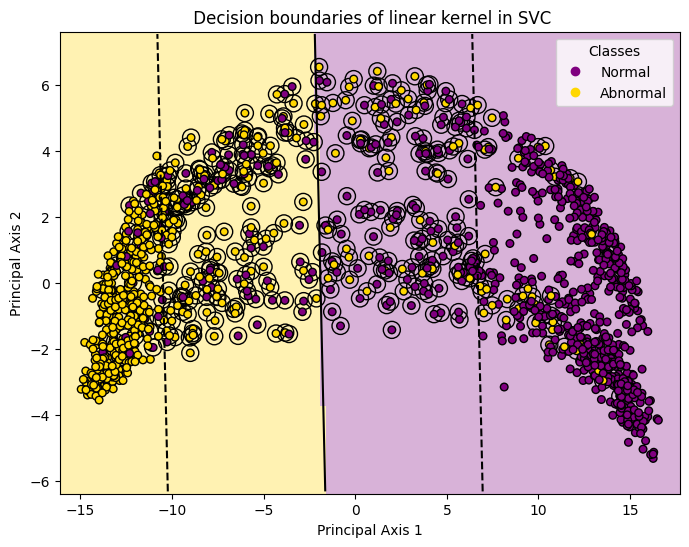

In [12]:
svm_classifier = data_vis.plot_with_decision_boundary("linear", reduced_embeddings, labels)

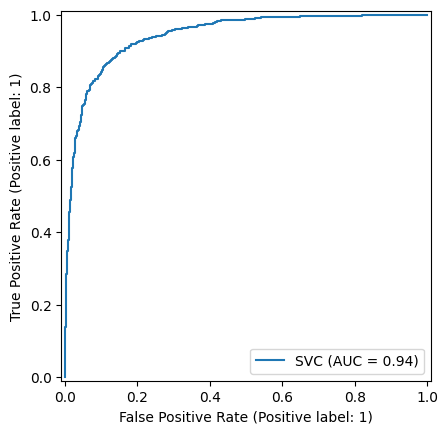

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()

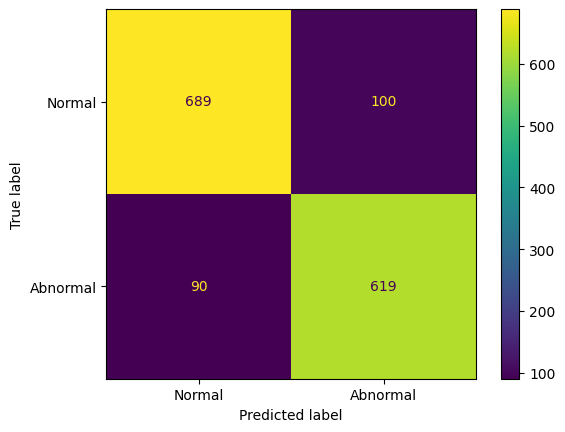

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svm_classifier, reduced_embeddings, labels, display_labels=["Normal", "Abnormal"])